
![alternatvie text](https://www.doc.zuv.fau.de//M/FAU-Logo/01_FAU_Kernmarke/Web/FAU_Kernmarke_Q_RGB_blue.svg)

# Perception in Robotics

Summer Semester 2025, Friedrich-Alexander-Universität Erlangen-Nürnberg

# 3. Exercise - Textures

In this exercise, we will combine filters into filter banks, with the objective to extract textures from a sample image from the [Kodak](https://r0k.us/graphics/kodak/) dataset. First, the **OpenCV** functions are used for the filter bank implementation. Then, the filter banks should be implemented without using the **OpenCV** package, solely relying on [numpy](https://numpy.org/doc/stable/user/absolute_beginners.html).

The solutions for the assignment may be a Python Notebook or .py files. The visual results can be integrated into the notebook or a PDF document.

## A. Gabor Filter Bank OpenCV

In this exercise, the [Gabor filter bank](https://en.wikipedia.org/wiki/Gabor_filter) should be implemented. The Gabor filter is a linear filter used to analyse textures. The filter bank should cover different orientations and scales. Therefore, use the **OpenCV** function *getGaborKernel* to generate the Gabor kernel. Use 4 different values for *ksize* and *theta* to define the filter bank at different scales and orientions. Then, apply the Gabor filter bank to the grayscale sample image by using the **OpenCV** function *filter2D* with the defined Gabor kernels. Visualize the different filters and the results after applying the filters to the image.

Example: [http://amroamroamro.github.io/mexopencv/opencv/gabor_demo.html](http://amroamroamro.github.io/mexopencv/opencv/gabor_demo.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 

In [2]:
# Define reasonable constants for the fixed parameters of the Gabor filter bank.
SIGMA = 5
LMBDA = 0.3
GAMMA = 0
PSI = 0

In [3]:
def get_gabor_filter_bank(ksizes, thetas):
    """ Generates a Gabor filter bank i.e., list of Gabor filters/kernels.
    Args
    ksizes      Kernel sizes (i.e., scales) for the kernels in the filter bank (Array of length N).
    thetas      Orientations of the kernels (Array of length N).

    Returns
    filter_bank Kernels of the Gabor filter bank.
    """
    filter_bank = []
    for ksize in ksizes:
        for theta in thetas:
            kernel = cv2.getGaborKernel((ksize, ksize), SIGMA, theta, LMBDA, GAMMA, PSI, ktype=cv2.CV_32F)
            filter_bank.append(kernel)
    return filter_bank

In [4]:
def apply_gabor_filter_bank(filter_bank, img):
    """ Apply the Gabor filter bank.
    Args 
    filter_bank List of filters to apply.
    img         Image to apply filters.

    Returns
    features    Features/Textures extracted by applying the Gabor filter bank.
    """
    features = []
    for i, kernel in enumerate(filter_bank):
        filtered = cv2.filter2D(img, cv2.CV_8UC3, kernel)
        features.append(filtered)
    return features

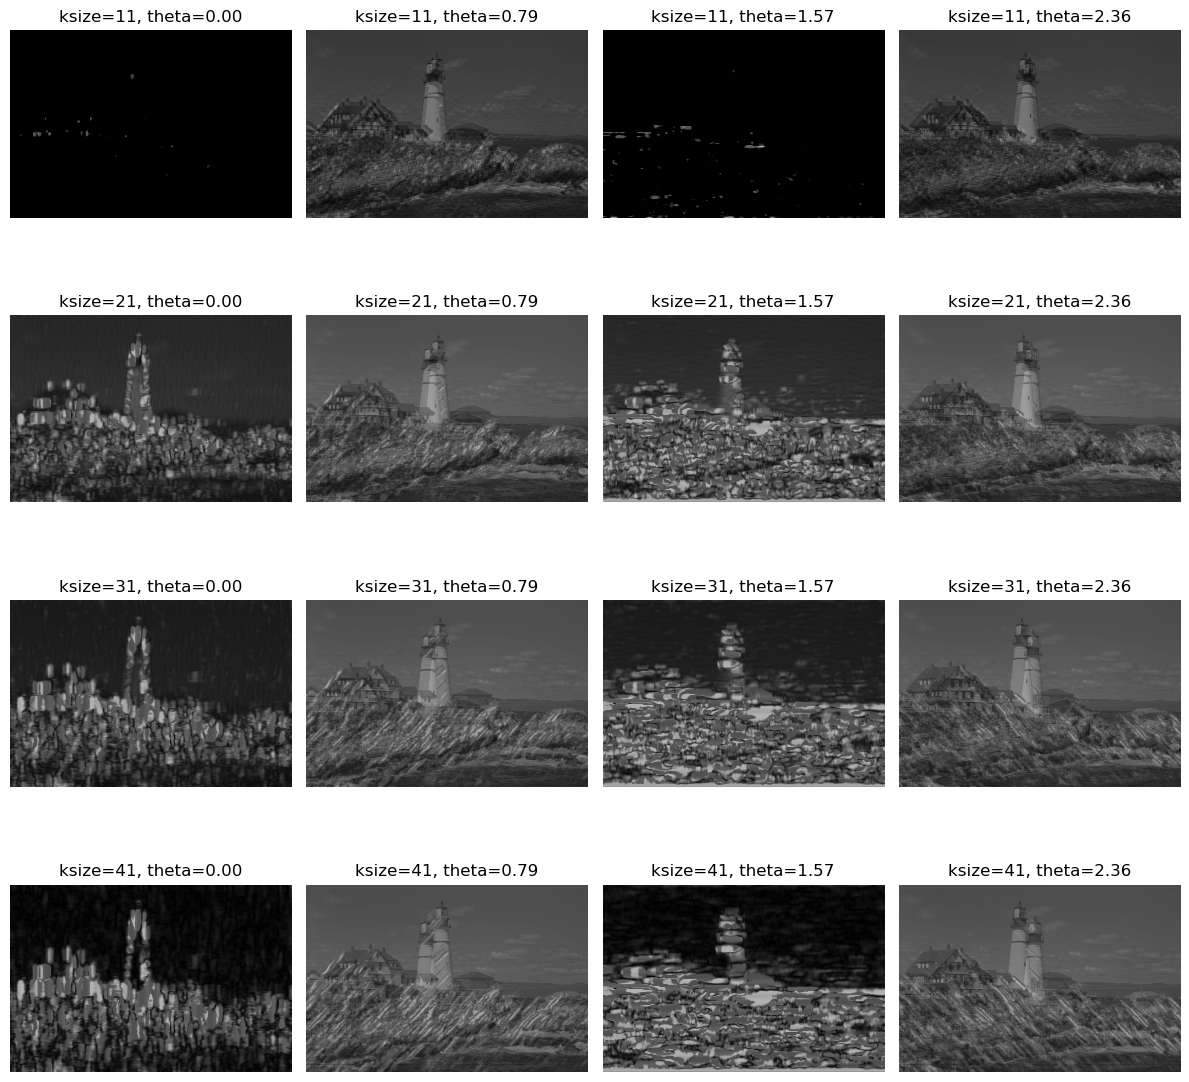

In [5]:
img = cv2.imread("kodim21.png", cv2.IMREAD_GRAYSCALE)

# Define scales and orientations
ksizes = [11, 21, 31, 41]
thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]

filter_bank = get_gabor_filter_bank(ksizes, thetas)
features = apply_gabor_filter_bank(filter_bank, img)

# Visualization
fig, axes = plt.subplots(len(ksizes), len(thetas), figsize=(12, 12))
for i in range(len(ksizes)):
    for j in range(len(thetas)):
        idx = i * len(thetas) + j
        axes[i, j].imshow(features[idx], cmap='gray')
        axes[i, j].set_title(f'ksize={ksizes[i]}, theta={thetas[j]:.2f}')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

## B. Gabor Filter Bank 

Now, the Gabor filter bank should be implemented without the **OpenCV** package. Again, visualize the different filters and the results when applied to the grayscale image. You may check your implementation by comparing with the kernels and results from **OpenCV** in A.

**Note:**  The filter has a real and an imaginary component representing orthogonal directions, use the real part for this exercise. Moreover, you may reuse your implementation of the convolution from the previous assignment to perform the filtering. Be aware of potentially different data types of the kernel (e.g., float) and image (e.g., uint8). Furthermore, pixel values might overflow 255. **OpenCV** handles this by clipping values during convolution to the range [0, 255].

In [6]:
def get_gabor_kernel(ksize, sigma, theta, lmbda, gamma, psi):
    """ Gabor feature extraction.
    Args
    ksize   Kernel size.
    sigma   Standard deviation of Gaussian envelope
    theta   Orientation of filter in radians.
    lmbda   Sinusiodal wavelength.
    gamma   Spatial aspect ratio (ellipticity) of the filter.
    psi     Phase offset of the filter in radians. 

    Returns
    gabor_filter Resulting kernel.
    """
    half = ksize // 2
    y, x = np.meshgrid(np.linspace(-half, half, ksize), np.linspace(-half, half, ksize))
    
    # Rotation
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)
    
    # Gabor kernel (real part)
    gb = np.exp(-0.5 * (x_theta**2 + (gamma**2) * y_theta**2) / (sigma**2)) * \
         np.cos(2 * np.pi * x_theta / lmbda + psi)
    
    return gb

In [7]:
def convolve2d(image, kernel):
    """
    Apply a 2D convolution manually.
    Args:
        image: Input grayscale image (2D numpy array).
        kernel: Filter kernel (2D numpy array).
    Returns:
        result: Filtered image.
    """
    image = image.astype(np.float32)
    kernel = kernel.astype(np.float32)
    k_h, k_w = kernel.shape
    pad_h = k_h // 2
    pad_w = k_w // 2
    
    # Pad image
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')
    result = np.zeros_like(image, dtype=np.float32)
    
    # Flip the kernel (standard in convolution)
    kernel_flipped = np.flip(kernel)

    # Convolve
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            region = padded[i:i+k_h, j:j+k_w]
            result[i, j] = np.sum(region * kernel_flipped)
    
    # Clip to [0, 255]
    result = np.clip(result, 0, 255)
    return result.astype(np.uint8)

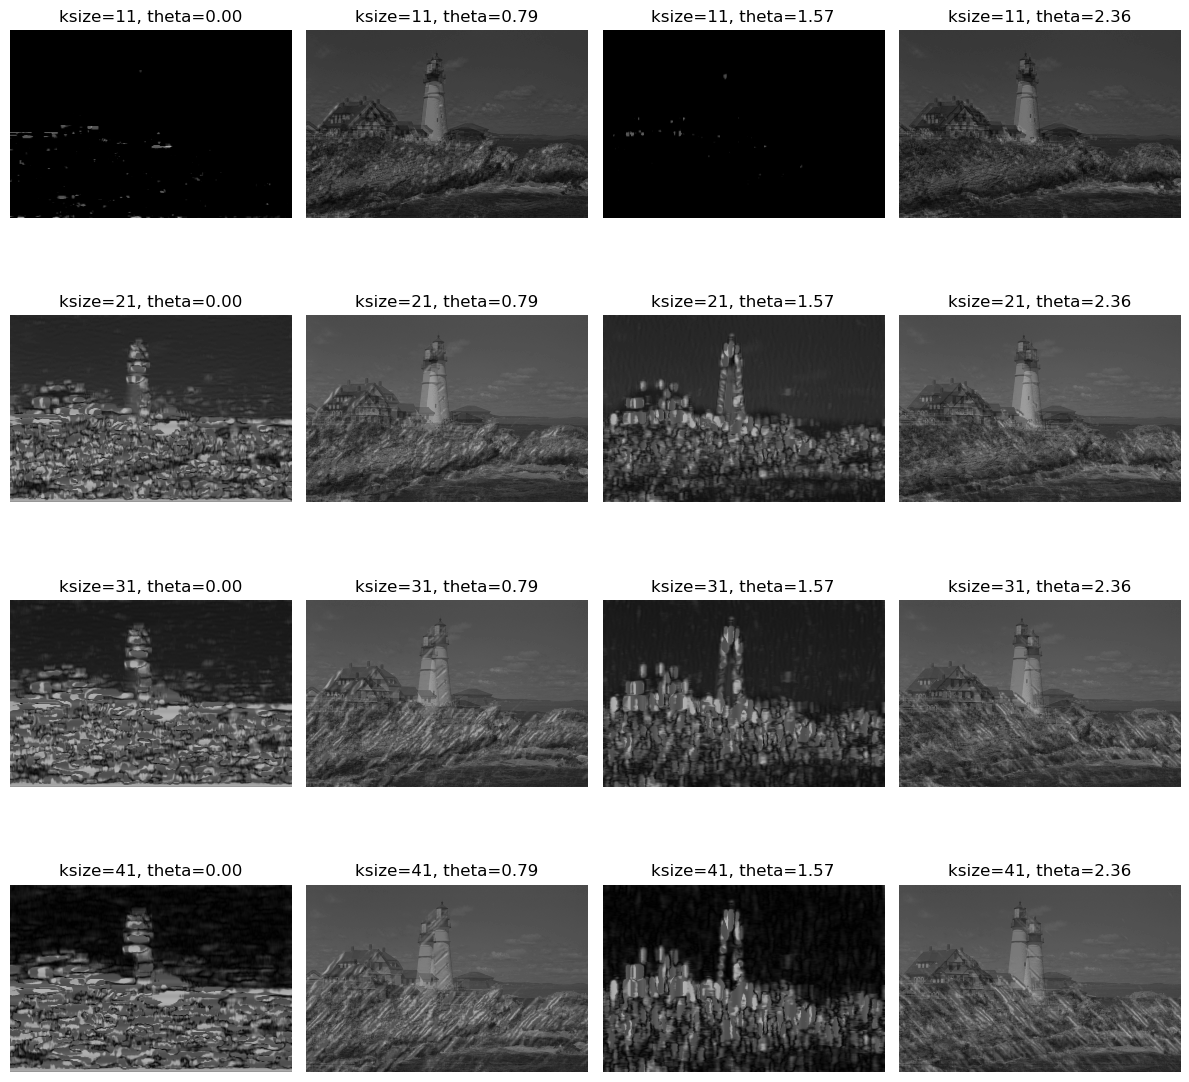

In [8]:
# Create and apply filter bank
features = []
kernels = []
for ksize in ksizes:
    for theta in thetas:
        kernel = get_gabor_kernel(ksize, SIGMA, theta, LMBDA, GAMMA, PSI)
        kernels.append(kernel)
        filtered = convolve2d(img, kernel)
        features.append(filtered)

# Visualize results
fig, axes = plt.subplots(len(ksizes), len(thetas), figsize=(12, 12))
for i in range(len(ksizes)):
    for j in range(len(thetas)):
        idx = i * len(thetas) + j
        axes[i, j].imshow(features[idx], cmap='gray')
        axes[i, j].set_title(f'ksize={ksizes[i]}, theta={thetas[j]:.2f}')
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()


## C. Leung-Malik Filter Bank 

In this exercise, the [Leung-Malik](https://people.eecs.berkeley.edu/~malik/papers/LM-3dtexton.pdf) filter bank should be implemented. The Leung-Malik filter bank contains 48 filters of different scales and orientations. It consists of first and second order derivatives of [Gaussians](https://mathworld.wolfram.com/GaussianFunction.html) at 6 orientations and 3 scales. Use $\sigma \in \left\{\sqrt{2}, 2\sqrt{2}, 3\sqrt{2} \right\}$ and $\theta \in \left\{0, \frac{\pi}{6}, \frac{2\pi}{6}, \frac{3\pi}{6}, \frac{4\pi}{6}, \frac{5\pi}{6} \right\}$ to define the filter bank at different scales and orientations, together with an elongation factor of 3 (i.e., $\sigma_x = \sigma$ and $\sigma_y = 3\sigma_x$). 
Furthermore, it encompasses 4 symmetric Gaussians (i.e., no elongation factor) with scales $\sigma$ and
8 [Laplacian of Gaussian (LoG)](https://en.wikipedia.org/wiki/Blob_detection#The_Laplacian_of_Gaussian) filters with $\sigma \in \left\{\sqrt{2}, 2\sqrt{2}, 3\sqrt{2}, 4\sqrt{2}\right\}$ and $3 \sigma$.

The following image depicts an example visualization of the kernels of the Leung-Malik filter bank taken from https://www.robots.ox.ac.uk/~vgg/research/texclass/figs/with/lmfilters.jpg.

![alternatvie text](https://www.robots.ox.ac.uk/~vgg/research/texclass/figs/with/lmfilters.jpg)

Finally, apply the Leung-Malik filter bank to the grayscale sample image. Visualize the different filter kernels and the results after the filters are applied to the image.   

Example: [https://www.robots.ox.ac.uk/~vgg/research/texclass/filters.html](https://www.robots.ox.ac.uk/~vgg/research/texclass/filters.html)

In [9]:
from scipy.ndimage import gaussian_filter, gaussian_laplace, rotate
from scipy.signal import convolve2d

In [10]:
def gaussian_derivative_kernel(sigma, order, elongation=3, size=None):
    """
    Generates a directional derivative of a Gaussian filter (first or second order).
    Elongation in y-direction: sigma_y = elongation * sigma_x
    """
    if size is None:
        size = int(np.ceil(6 * sigma)) | 1  # Make size odd
    
    x = np.linspace(-size//2, size//2, size)
    y = np.linspace(-size//2, size//2, size)
    xx, yy = np.meshgrid(x, y)
    
    sigma_x = sigma
    sigma_y = elongation * sigma

    # Gaussian
    g = np.exp(-(xx**2 / (2*sigma_x**2) + yy**2 / (2*sigma_y**2)))
    
    if order == 1:
        g = -xx / (sigma_x**2) * g
    elif order == 2:
        g = ((xx**2 - sigma_x**2) / (sigma_x**4)) * g
    
    return g

In [11]:
def rotate_kernel(kernel, theta):
    """Rotate kernel to desired orientation."""
    return rotate(kernel, np.degrees(theta), reshape=False, mode='nearest')

In [12]:
def get_lm_filter_bank(scales, thetas):
    """ Generates a Leung-Malik filter bank.
    Args
    scales      Kernel sizes (i.e., scales) for the kernels in the filter bank (Array of length 3).
    thetas      Orientations of the first and second order derivative Gaussian kernel (Array of length 6).

    Returns
    filter_bank Kernels of the Leung-Malik filter bank.
    """
    filter_bank = []

    for sigma in scales:
        for theta in thetas:
            # First derivative of Gaussian (elongated)
            kernel1 = gaussian_derivative_kernel(sigma, order=1)
            kernel1 = rotate_kernel(kernel1, theta)
            filter_bank.append(kernel1)
            
            # Second derivative of Gaussian (elongated)
            kernel2 = gaussian_derivative_kernel(sigma, order=2)
            kernel2 = rotate_kernel(kernel2, theta)
            filter_bank.append(kernel2)

    # 4 isotropic Gaussians
    for sigma in scales:
        size = int(np.ceil(6 * sigma)) | 1
        x = np.linspace(-size//2, size//2, size)
        y = np.linspace(-size//2, size//2, size)
        xx, yy = np.meshgrid(x, y)
        g = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
        filter_bank.append(g)

    # 8 Laplacian of Gaussian (LoG)
    for sigma in [np.sqrt(2), 2*np.sqrt(2), 3*np.sqrt(2), 4*np.sqrt(2)]:
        for mult in [1, 3]:
            s = mult * sigma
            size = int(np.ceil(6 * s)) | 1
            log = gaussian_laplace(np.zeros((size, size)), sigma=s)
            filter_bank.append(log)

    return filter_bank

In [13]:
def apply_lm_filter_bank(filter_bank, img):
    """ Apply the Leung-Malik filter bank.
    Args 
    filter_bank List of filters to apply.
    img         Image to apply filters.

    Returns
    features    Features/Textures extracted by applying the Leung-Malik filter bank.
    """

    features = []
    img = img.astype(np.float32)
    
    for kernel in filter_bank:
        k = kernel.astype(np.float32)
        filtered = convolve2d(img, k, mode='same', boundary='symm')
        filtered = np.clip(filtered, 0, 255)
        features.append(filtered.astype(np.uint8))
    
    return features

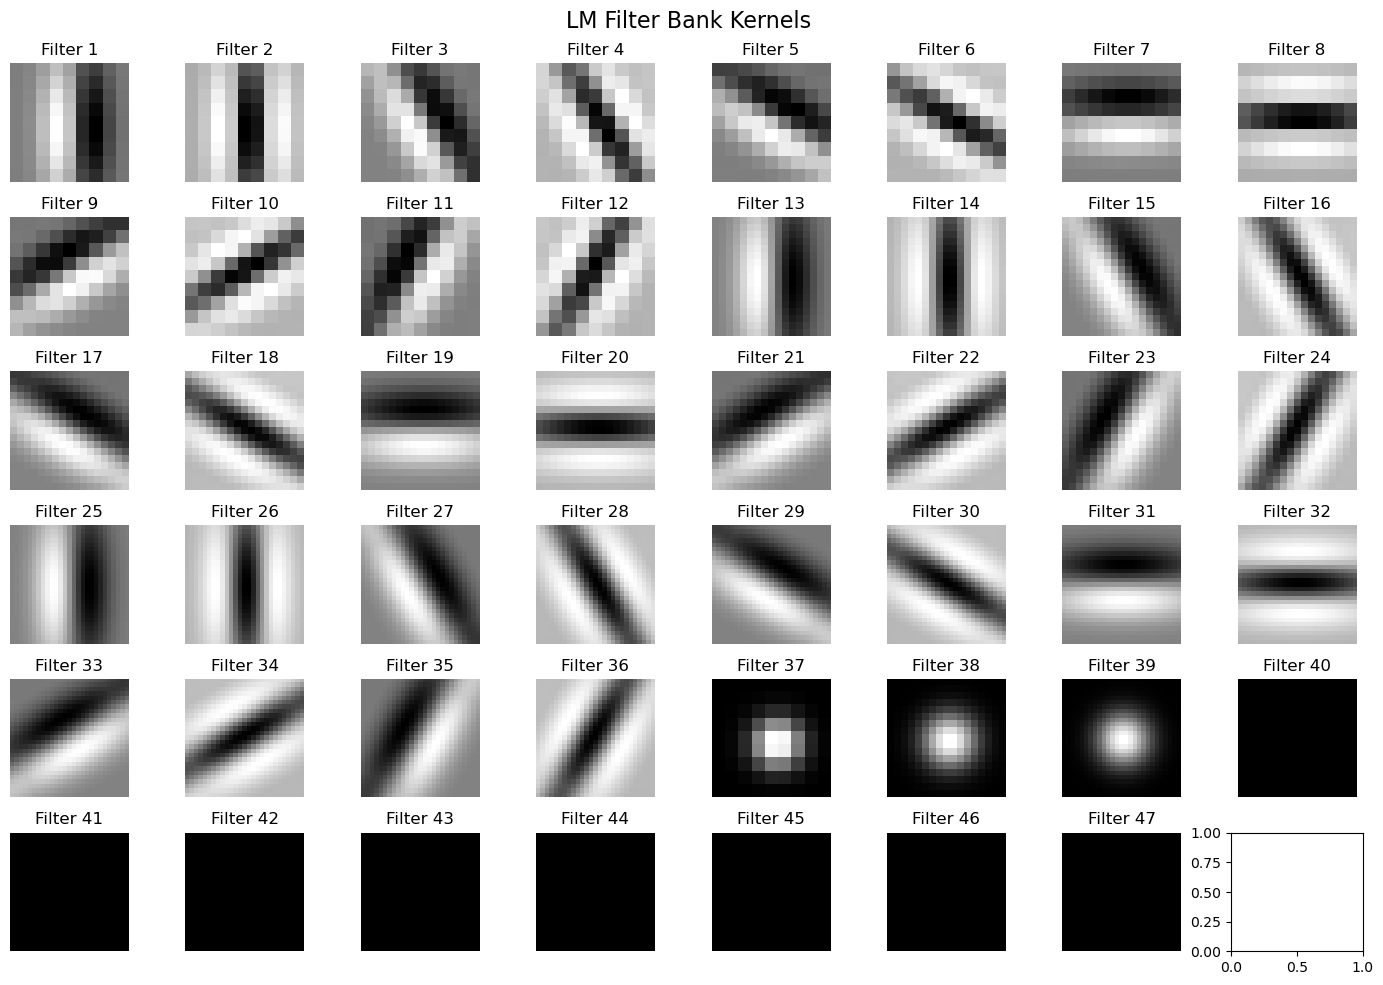

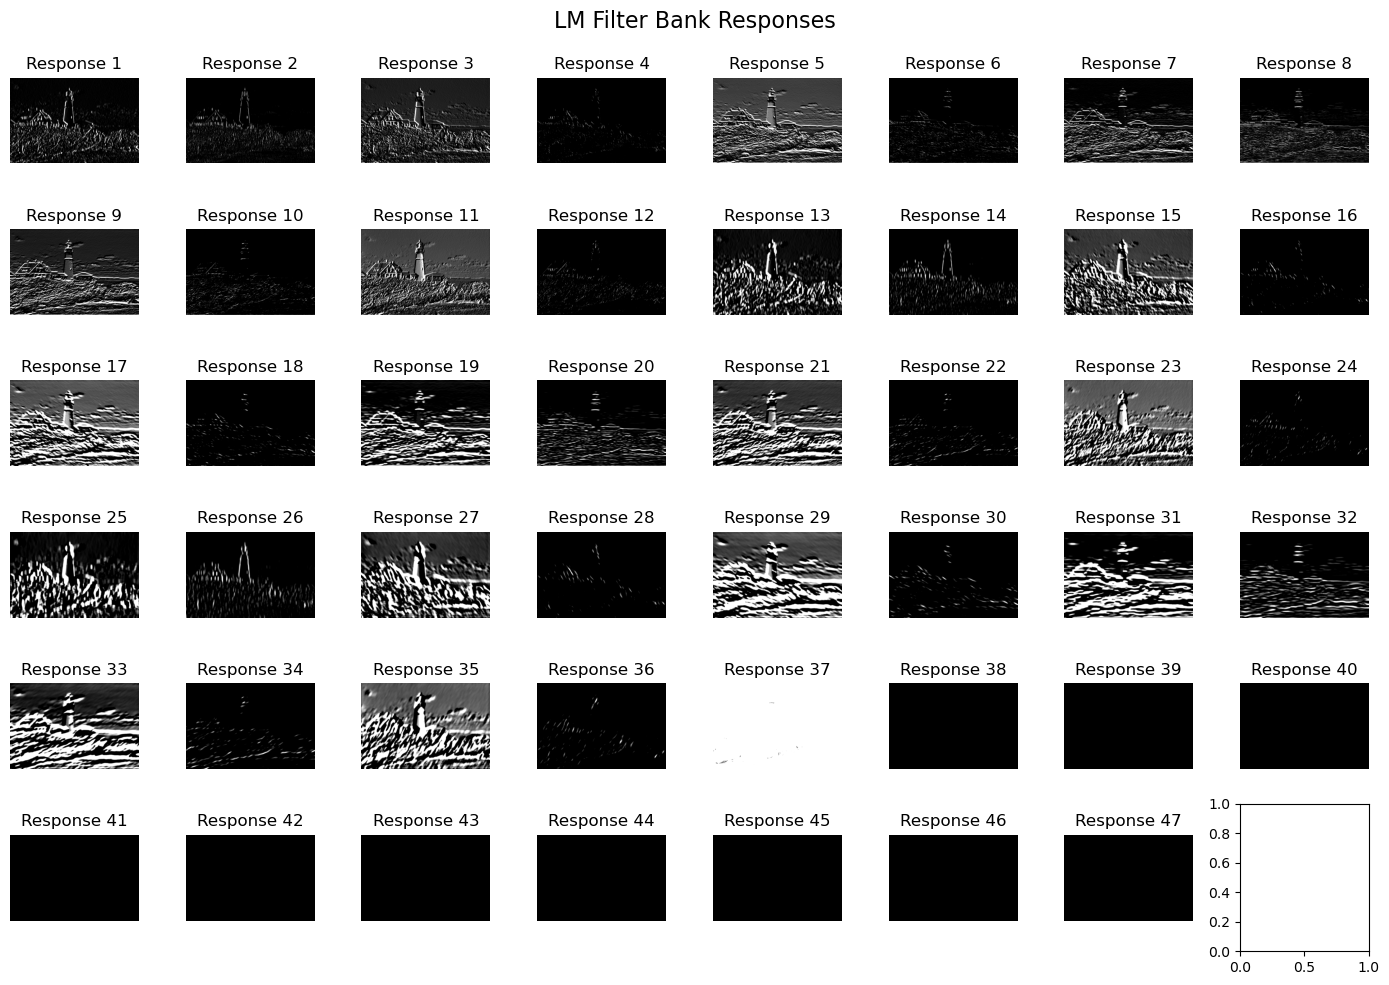

In [14]:
scales = [np.sqrt(2), 2*np.sqrt(2), 3*np.sqrt(2)]
thetas = [0, np.pi/6, 2*np.pi/6, 3*np.pi/6, 4*np.pi/6, 5*np.pi/6]# New values


filter_bank = get_lm_filter_bank(scales, thetas)
features = apply_lm_filter_bank(filter_bank, img)

# Visualize a few kernels
fig, axes = plt.subplots(6, 8, figsize=(14, 10))
for i, ax in enumerate(axes.flat):
    if i < len(filter_bank):
        ax.imshow(filter_bank[i], cmap='gray')
        ax.set_title(f'Filter {i+1}')
        ax.axis('off')
plt.suptitle("LM Filter Bank Kernels", fontsize=16)
plt.tight_layout()
plt.show()

# Visualize filter responses
fig, axes = plt.subplots(6, 8, figsize=(14, 10))
for i, ax in enumerate(axes.flat):
    if i < len(features):
        ax.imshow(features[i], cmap='gray')
        ax.set_title(f'Response {i+1}')
        ax.axis('off')
plt.suptitle("LM Filter Bank Responses", fontsize=16)
plt.tight_layout()
plt.show()